# Import Required Packages

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../src/neural_network')
from predict import *

2023-09-22 18:39:28.479202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading Example Trajectories

In [2]:
trajectory1 = pd.read_csv('trajectory_1.csv')
trajectory2 = pd.read_csv('trajectory_2.csv')
trajectory3 = pd.read_csv('trajectory_3.csv')

# Visualization Functions

In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
import contextily as ctx

def format_duration(seconds, unit='sec'):
    """
    Display time duration in HH:MM:SS or MM:SS format.
    
    Parameters:
    - seconds: The time in seconds or minutes.
    - unit: The unit of the input time ('sec' for seconds, 'min' for minutes).

    Returns:
    - A string representation of the time in either HH:MM:SS or MM:SS format.
    """
    
    if unit == 'min':
        seconds *= 60
    
    if np.isnan(seconds):
        return np.nan
    
    hours = 0
    if seconds >= 60*60:
        hours = seconds // (60*60)
        seconds %= (60*60)
    
    minutes = seconds // 60
    seconds %= 60
    
    if hours:
        return f"{int(hours):02}:{int(minutes):02}:{int(seconds):2}"
    else:
        return f"{int(minutes):02}:{int(seconds):02}"

def plot_gps_route(ax,
                   GPS_df,
                   trip_ID=None,
                   col_ID='TripID',
                   label='y_hat_labels',
                   n_driving_points=30,
                   col_lat='lat',
                   col_lon='lon',
                   title='',
                   basemap=True,
                   ax_legend=True):
    
    if trip_ID is not None:
        trip_test = GPS_df[GPS_df[col_ID]==trip_ID].reset_index(drop=True).reset_index()
    else:
        trip_test = GPS_df


    gdf=gpd.GeoDataFrame(data=trip_test,
                         geometry=trip_test[[col_lat, col_lon]]\
                             .apply(lambda x: Point(x[col_lon], x[col_lat]), axis=1).values,
                         crs='EPSG:4326')

    ## If more than one search point predicted in the labels then we can visualize the search
    if (gdf[f'{label}']=='searching').sum()>1:

        idx_drive_max = gdf[gdf['y_hat_labels']=='driving'].iloc[-1].name

        ## route points
        gdf[gdf[f'{label}']=='driving'][idx_drive_max-n_driving_points:]\
                .to_crs('EPSG:3857').plot(ax=ax, color='blue', label='Driving',zorder=2)
        gdf[gdf[f'{label}']=='searching'].to_crs('EPSG:3857').plot(ax=ax, color='tab:red', label='Searching')

        ## route lines
        begin_loc_search = gdf[gdf[f'{label}']=='searching'].iloc[0].name
        gpd.GeoDataFrame(geometry=[LineString(gdf[idx_drive_max-n_driving_points:begin_loc_search+1]['geometry'].values)],
                         crs='epsg:4326').to_crs('EPSG:3857').plot(ax=ax, color='tab:blue')
        gpd.GeoDataFrame(geometry=[LineString(gdf[gdf[f'{label}']=='searching']['geometry'].values)],
                         crs='epsg:4326').to_crs('EPSG:3857').plot(ax=ax, color='tab:red')

        ## main points
        # gdf.iloc[[0]].to_crs('EPSG:3857').plot(color='blue',edgecolor='black', markersize=200, ax=ax,lw=3, label='Origin')
        gdf[gdf[f'{label}']=='searching'].iloc[[0]].to_crs('EPSG:3857').plot(ax=ax, edgecolor='black',lw=3, zorder=2,
                                                       markersize=350,color='red', label='Search Starting Point')
        gdf[gdf[f'{label}']=='searching'].iloc[[-1]].to_crs('EPSG:3857').plot(ax=ax, edgecolor='black',lw=3, zorder=2,
                                                        label='Parking Spot',markersize=350,color='tab:orange')

        psd_tmp = gdf[gdf[label] == "searching"]['remainingTime'].iloc[0]
            
    else:
        
        gdf[-n_driving_points:]\
                .to_crs('EPSG:3857').plot(ax=ax, color='blue', label='Driving',zorder=2)
        gpd.GeoDataFrame(geometry=[LineString(gdf[-n_driving_points:]['geometry'].values)],
                         crs='epsg:4326').to_crs('EPSG:3857').plot(ax=ax, color='tab:blue')
        psd_tmp=0
    

    xlim=ax.get_xlim()
    ylim=ax.get_ylim()

    ax.set_xlim([xlim[0]-10,xlim[1]+10])
    ax.set_ylim([ylim[0],ylim[1]+10])
    ax.set_axis_off()
    if ax_legend:
        ax.legend()

    ax.set_title(f'{title}\nParking Search Duration: {format_duration(psd_tmp)}')
    
    if basemap:
        ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
        #ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)
        #ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)

import folium

def visualize_trip(df, tripID=None, label='label', col_ID='TripID'):
    
    if tripID!=None:     
        # Filter the dataframe for the specific tripID
        trip_data = df[df[col_ID] == tripID]
    else:
        trip_data=df

    # Colors based on label
    color_map = {
        'driving': 'blue',
        'searching': 'red',
        'walking': 'green'
    }

    # Use the last point as the center
    last_point = trip_data.iloc[-1]
    m = folium.Map(location=[last_point['lat'], last_point['lon']], zoom_start=15)

    # Iterate through the rows in trip_data and add markers to the map
    for _, row in trip_data.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,  # Adjust this as needed to change the size of the circle markers
            popup=f"Speed: {row['speed_kmh']}",
            color=color_map[row[label]],
            fill=True,
            fill_color=color_map[row[label]],
            fill_opacity=1.0
        ).add_to(m)

    return m

# Single Trajectory

**Example 1:**

In [4]:
traj1_pred = park_search_predict(trajectory1, 
                                 model_path='../model/ParkingSearchPrediction.h5',
                                 p_search='auto',
                                 col_ID=None,
                                 col_time='timestamp',
                                 col_speed='speed_kmh',
                                 col_lat='lat',
                                 col_lon='lon',
                                 verbose=1)

2023-09-22 18:39:30.911098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 [==============================] - 0s 1ms/step


In [5]:
traj1_pred

lon        lat           timestamp  speed_kmh      label   
0   8.677233  50.130181 2021-02-22 20:11:11   0.000000    driving  \
1   8.677274  50.130207 2021-02-22 20:11:39   4.195406    driving   
2   8.677753  50.130292 2021-02-22 20:11:45  20.599526    driving   
3   8.678072  50.130509 2021-02-22 20:11:51  19.489262    driving   
4   8.678317  50.130747 2021-02-22 20:11:57  16.513604    driving   
..       ...        ...                 ...        ...        ...   
63  8.677521  50.120949 2021-02-22 20:18:56  16.292420  searching   
64  8.677823  50.121082 2021-02-22 20:19:02  15.113641  searching   
65  8.678088  50.121218 2021-02-22 20:19:08  17.950489  searching   
66  8.678487  50.121410 2021-02-22 20:19:14  14.095193  searching   
67  8.678603  50.121480 2021-02-22 20:19:20   3.342689  searching   

    distToParkingSpot  speed_lag1  speed_lag2  speed_lag3  speed_lag4  ...   
0          972.423844    0.000000    0.000000    0.000000    0.000000  ...  \
1          975.011992    0.000000    0.000000    0.000000    0.000000  ...   
2          981.721493    4.195406    0.000000    0.000000    0.000000  ...   
3         1004.692344   20.599526    4.195406    0.000000    0.000000  ...   
4         1030.645062   19.489262   20.599526    4.195406    0.000000  ...   
..                ...         ...         ...         ...         ...  ...   
63          97.143755   15.552223   16.396489   16.794778   27.513246  ...   
64          71.070212   16.292420   15.552223   16.396489   16.794778  ...   
65          46.870422   15.113641   16.292420   15.552223   16.396489  ...   
66          11.356926   17.950489   15.113641   16.292420   15.552223  ...   
67           0.000000   14.095193   17.950489   15.113641   16.292420  ...   

    sampRate_lag1  sampRate_lag2  sampRate_lag3  sampRate_lag4  sampRate_lag5   
0             0.0            0.0            0.0            0.0            0.0  \
1             0.0            0.0            0.0            0.0            0.0   
2            28.0            0.0            0.0            0.0            0.0   
3             6.0           28.0            0.0            0.0            0.0   
4             6.0            6.0           28.0            0.0            0.0   
..            ...            ...            ...            ...            ...   
63            6.0            6.0            6.0            6.0            6.0   
64            6.0            6.0            6.0            6.0            6.0   
65            6.0            6.0            6.0            6.0            6.0   
66            6.0            6.0            6.0            6.0            6.0   
67            6.0            6.0            6.0            6.0            6.0   

    remainingTime   y_hat_p  duration_to_previous  sampRateMedian   
0           489.0  0.008394                   0.0             6.0  \
1           461.0  0.014293                  28.0             6.0   
2           455.0  0.008526                   6.0             6.0   
3           449.0  0.017735                   6.0             6.0   
4           443.0  0.014265                   6.0             6.0   
..            ...       ...                   ...             ...   
63           24.0  0.488099                   6.0             6.0   
64           18.0  0.629855                   6.0             6.0   
65           12.0  0.652998                   6.0             6.0   
66            6.0  0.690479                   6.0             6.0   
67            0.0  0.748613                   6.0             6.0   

    y_hat_labels  
0        driving  
1        driving  
2        driving  
3        driving  
4        driving  
..           ...  
63     searching  
64     searching  
65     searching  
66     searching  
67     searching  

[68 rows x 22 columns]

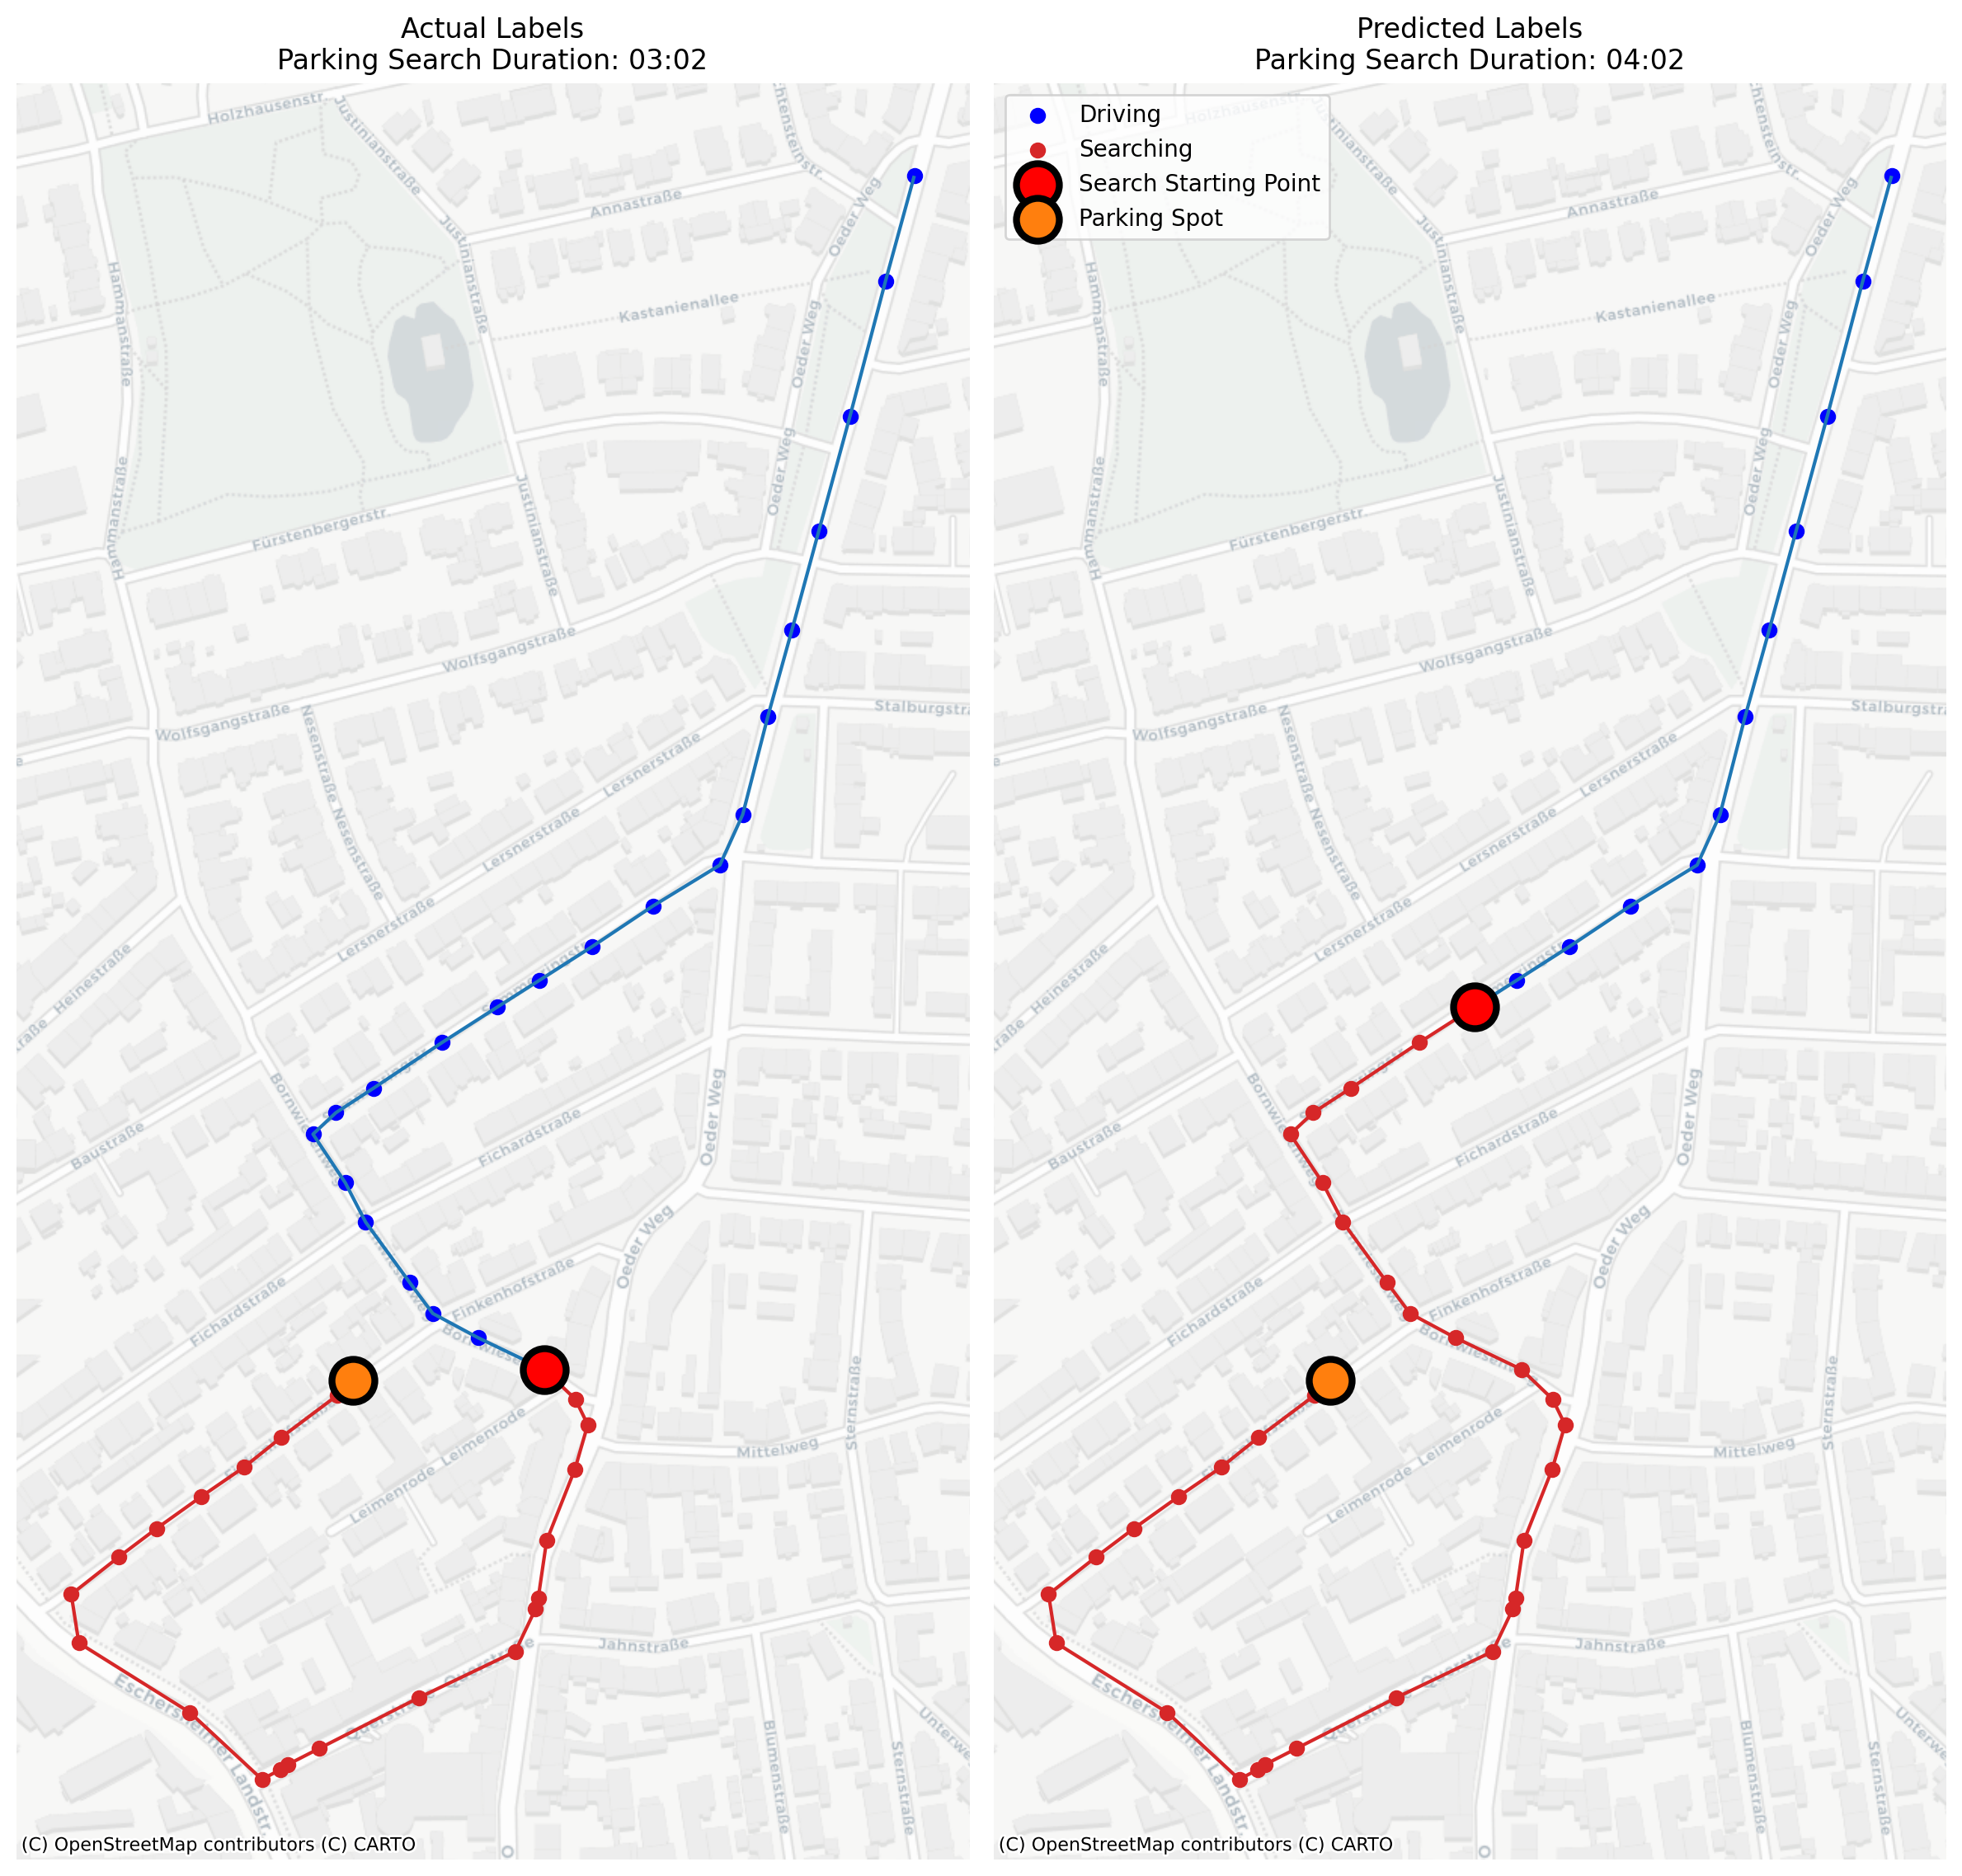

In [14]:
fig, axs = plt.subplots(1,2, figsize=(12,12), dpi=200)
plot_gps_route(axs[0], traj1_pred, n_driving_points=10, label='label', title='Actual Labels', ax_legend=False)
plot_gps_route(axs[1], traj1_pred, n_driving_points=10, label='y_hat_labels', title='Predicted Labels')
plt.tight_layout()

**Example 2:**

In [7]:
traj2_pred = park_search_predict(trajectory2, 
                                 model_path='../model/ParkingSearchPrediction.h5',
                                 col_ID=None,
                                 col_time='timestamp',
                                 col_speed='speed_kmh',
                                 col_lat='lat',
                                 col_lon='lon',
                                 verbose=1)

4/4 [==============================] - 0s 975us/step


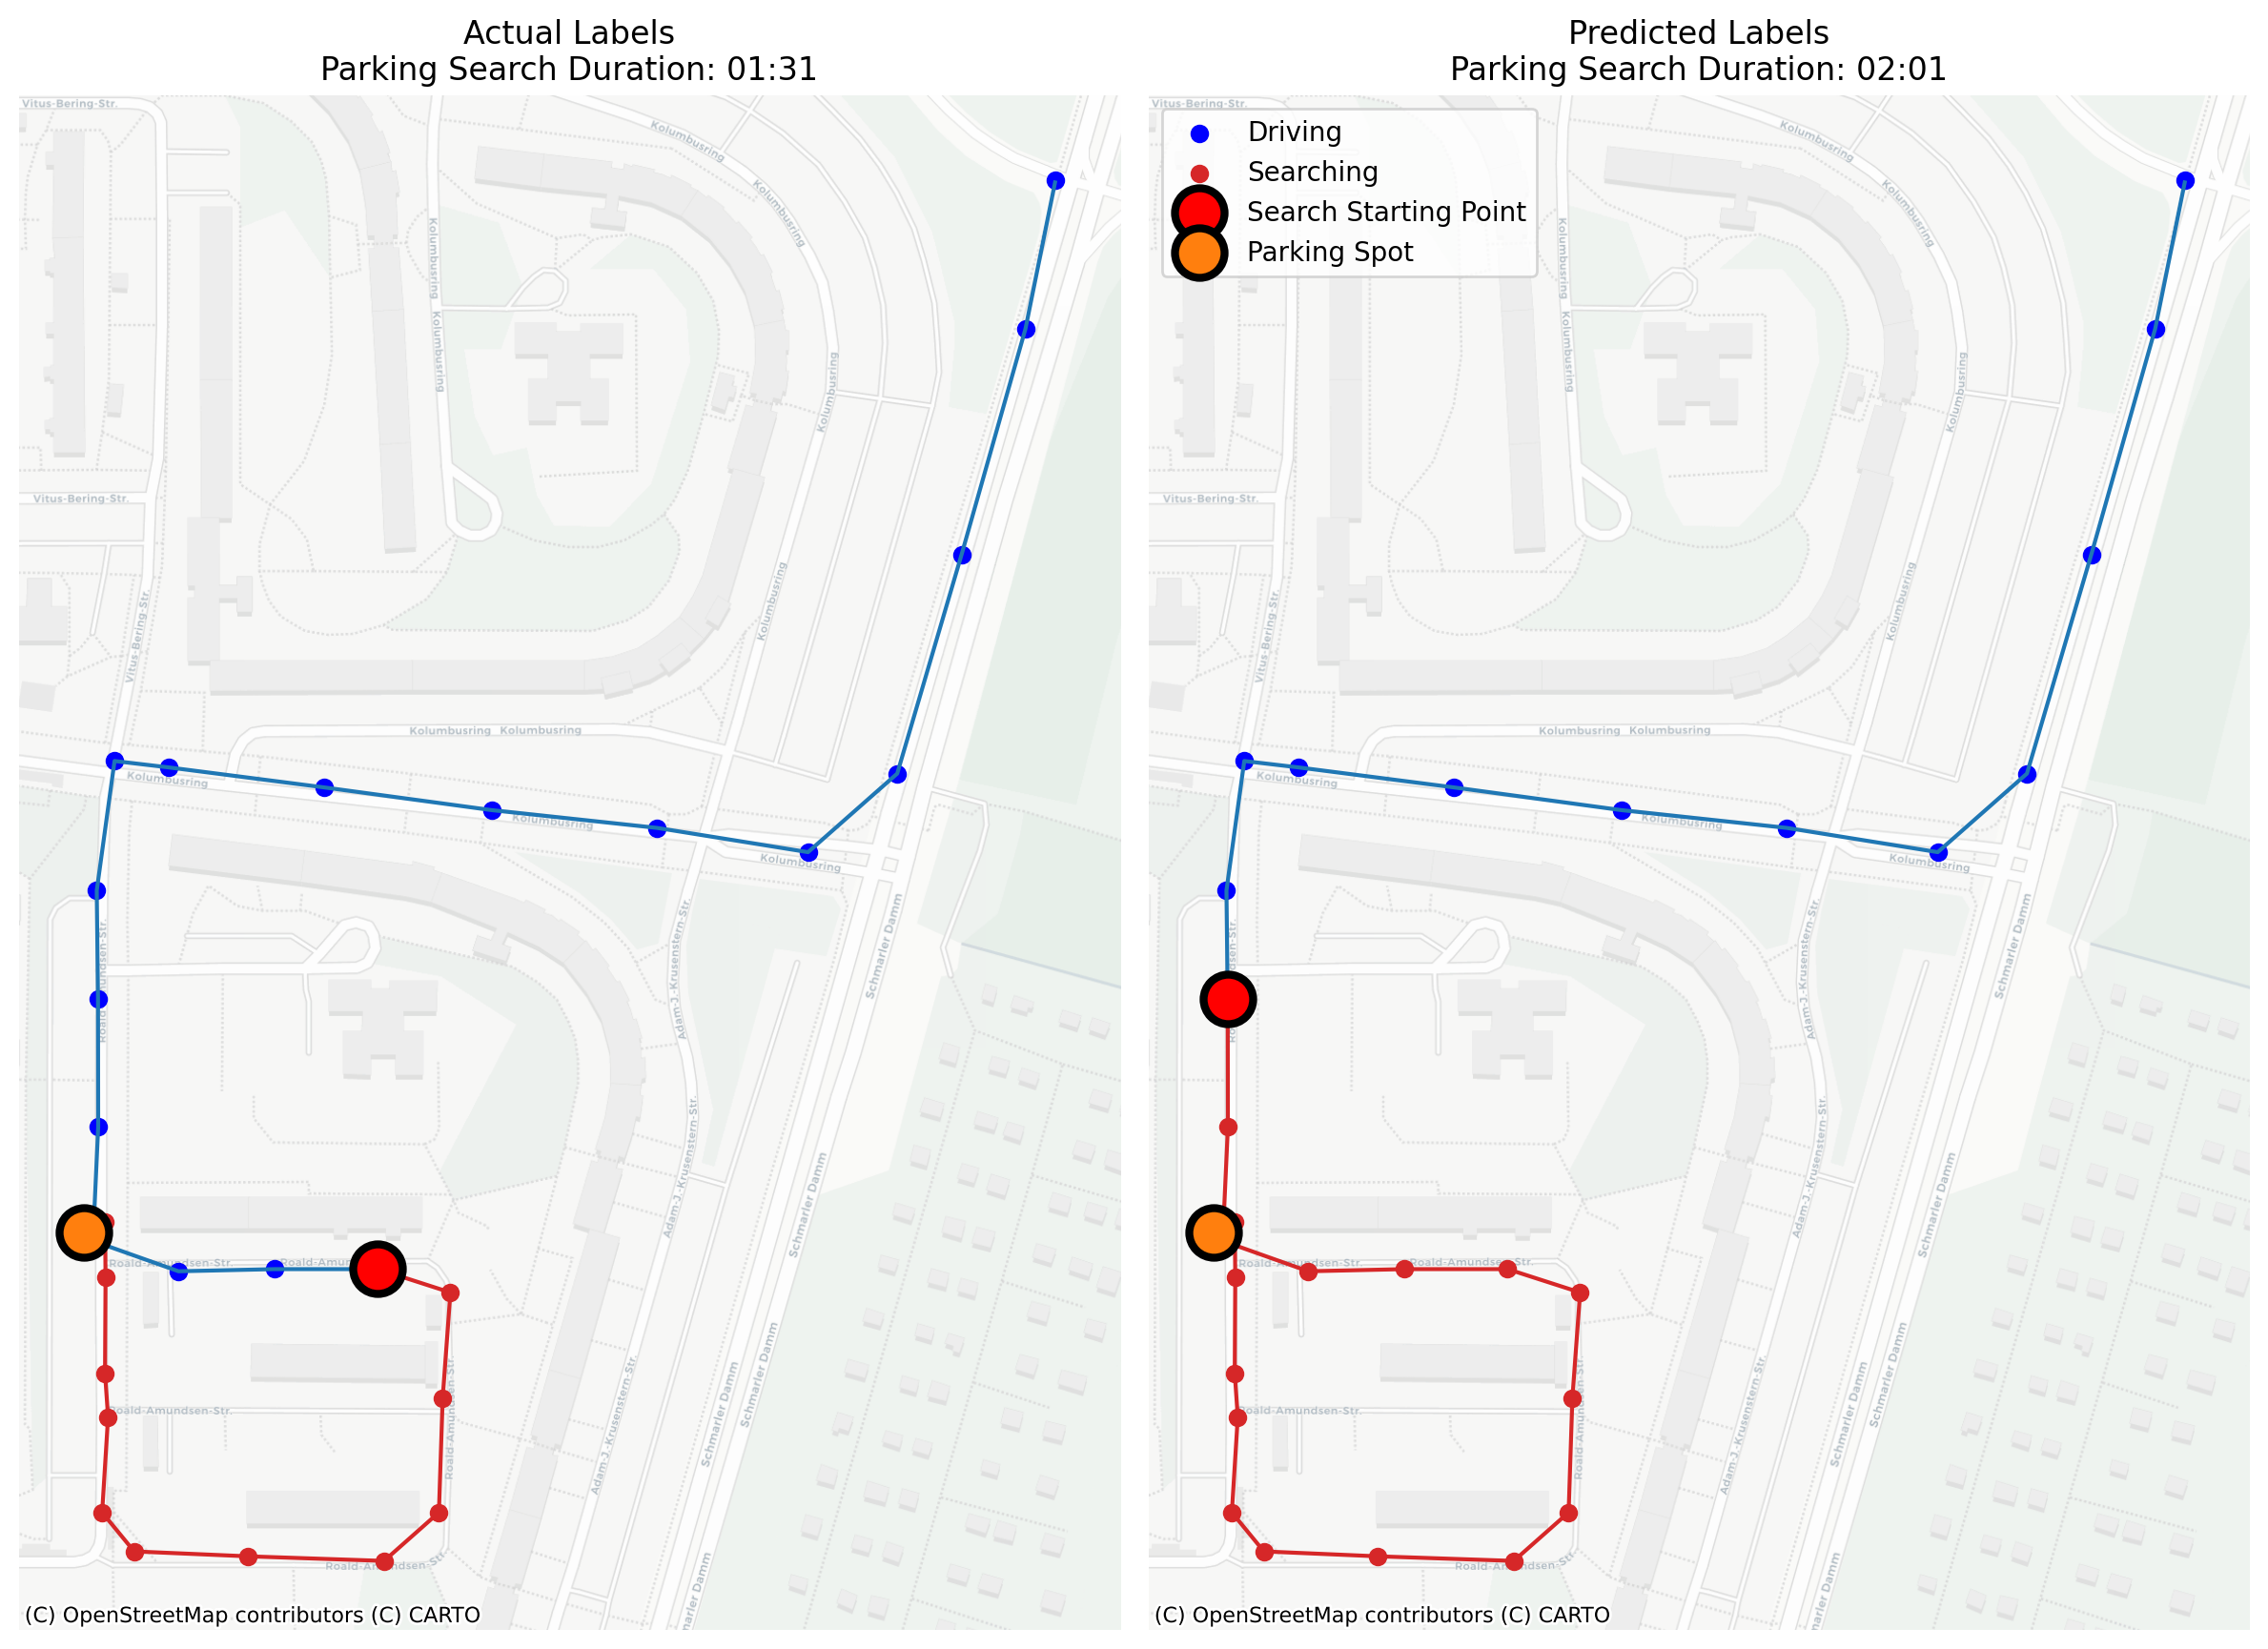

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12,12), dpi=200)
plot_gps_route(axs[0], traj2_pred, n_driving_points=10, label='label', title='Actual Labels', ax_legend=False)
plot_gps_route(axs[1], traj2_pred, n_driving_points=10, label='y_hat_labels', title='Predicted Labels')
plt.tight_layout()

**Example 3:**

In [9]:
traj3_pred = park_search_predict(trajectory3, 
                                 model_path='../model/ParkingSearchPrediction.h5',
                                 col_ID=None,
                                 col_time='timestamp',
                                 col_speed='speed_kmh',
                                 col_lat='lat',
                                 col_lon='lon',
                                 verbose=1)

3/3 [==============================] - 0s 1ms/step


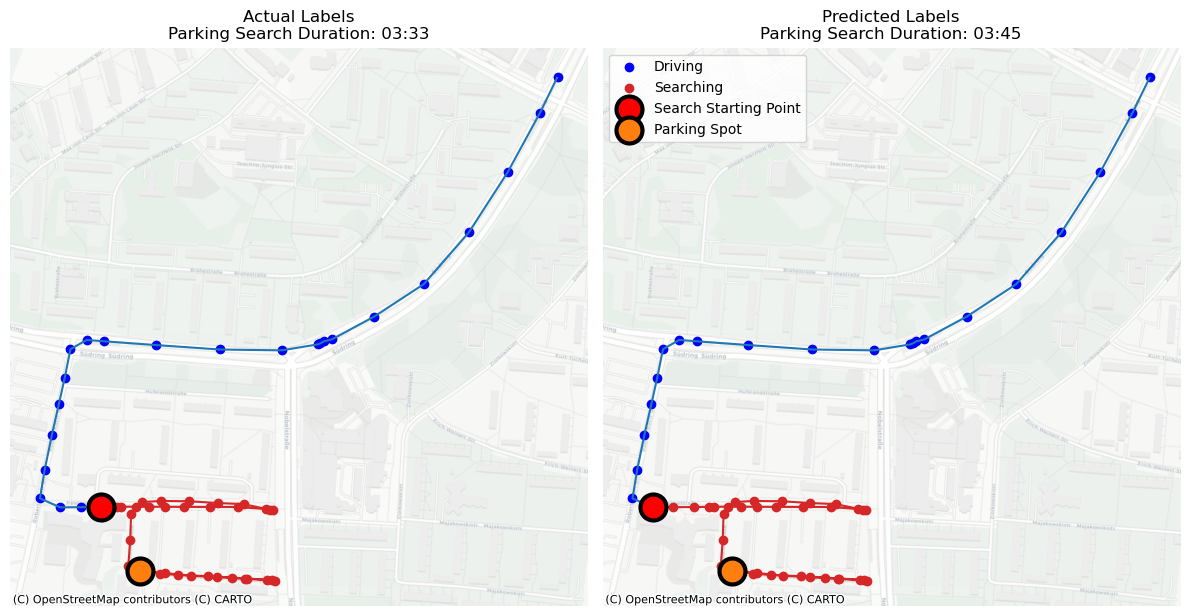

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,12), dpi=100)
plot_gps_route(axs[0], traj3_pred, n_driving_points=20, label='label', title='Actual Labels', ax_legend=False)
plot_gps_route(axs[1], traj3_pred, n_driving_points=20, label='y_hat_labels', title='Predicted Labels')
plt.tight_layout()

# Multiple Trajectories

In [11]:
trajectory1['TripID']='Trip#1'
trajectory2['TripID']='Trip#2'
trajectory3['TripID']='Trip#3'

traj_df = pd.concat([trajectory1, trajectory2, trajectory3])

In [12]:
traj_df_pred = park_search_predict(traj_df, 
                                   model_path='../model/ParkingSearchPrediction.h5',
                                   p_search='auto',
                                   col_ID='TripID',
                                   col_time='timestamp',
                                   col_speed='speed_kmh',
                                   col_lat='lat',
                                   col_lon='lon',
                                   verbose=1)

9/9 [==============================] - 0s 779us/step


In [13]:
visualize_trip(traj_df_pred, tripID='Trip#3', label='y_hat_labels')